In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

## Data Processing
### Data is ingested and made suitable for a CNN

In [2]:
IMAGE_DIRECTORY_1 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_1"
IMAGE_DIRECTORY_2 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_2"
trimmed_data = pd.read_csv("trimmed_dataset.csv",index_col=0)
trimmed_data.head()

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [3]:
trimmed_data.sort_values(by="lesion_id",axis=0,inplace=True)
trimmed_data["dx"]=trimmed_data["dx"].map({"bkl":0,"akiec":1,"bcc":2,
                                           "df":3,"mel":4,"nv":5,"vasc":6})

trimmed_data.drop("lesion_id",axis=1,inplace=True)
trimmed_data.set_index("image_id",inplace=True)
trimmed_data.head()

,dx
image_id,
ISIC_0028498,5
ISIC_0025346,5
ISIC_0027859,0
ISIC_0032622,4
ISIC_0033848,4


In [4]:
row_keys = trimmed_data.columns.values
row_keys

array(['dx'], dtype=object)

## Image collection and transformation
### Resize to uniform 200x200x3

In [5]:
import cv2
import math
from pathlib import Path
from skimage.util import img_as_float
j=0
images = []
image_ids = []
IMG_SIZE= 250
min_w, min_h = math.inf, math.inf 
dim = (IMG_SIZE,IMG_SIZE)
dirs = [IMAGE_DIRECTORY_1,IMAGE_DIRECTORY_2]
for directory in dirs:
    j=0
    for image_name in os.listdir(directory):
        
        filepath = os.path.join(directory,image_name)
        j+=1

        if j>100:
            break
        new_image = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        new_image = img_as_float(new_image)
        resized_image = cv2.resize(new_image,dim)
        # plt.imshow(resized_image)
        # plt.show()
        # break
        
        images.append(resized_image)
        image_ids.append(image_name[:-4])

## Model

### Create training/testing data, create models and use data for fitting

In [6]:
from skimage import data, color, morphology, img_as_float
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

C:\Users\isaac\AppData\Local\Temp\ipykernel_20852\3878886668.py:17: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ax[3].imshow(denoise_bilateral(image- white_res + black_res, sigma_color=0.01, sigma_spatial=15,
C:\Users\isaac\AppData\Local\Temp\ipykernel_20852\3878886668.py:22: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ax[4].imshow(denoise_bilateral(image- white_res + black_res, sigma_color=0.02, sigma_spatial=15,
C:\Users\isaac\AppData\Local\Temp\ipykernel_20852\3878886668.py:27: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ax[5].imshow(denoise_bilateral(image- white_res + black_res, sigma_color=0.03, sigma_spatial=15,


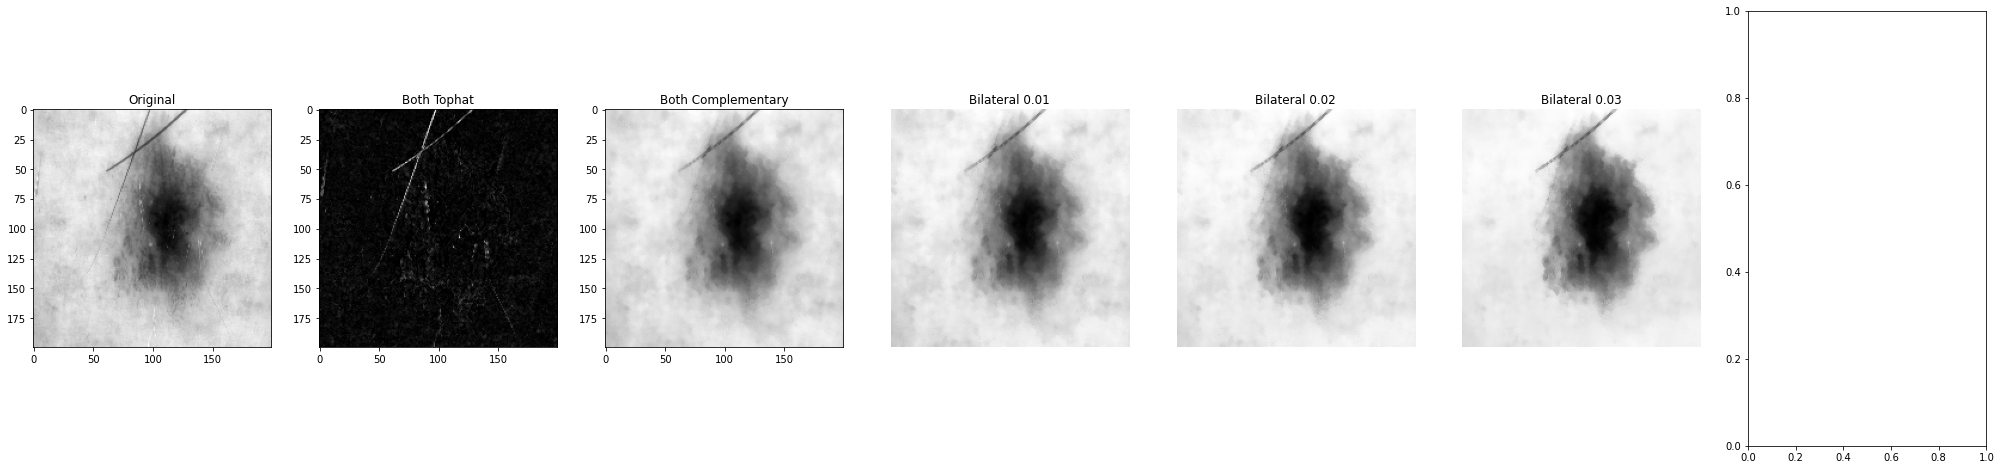

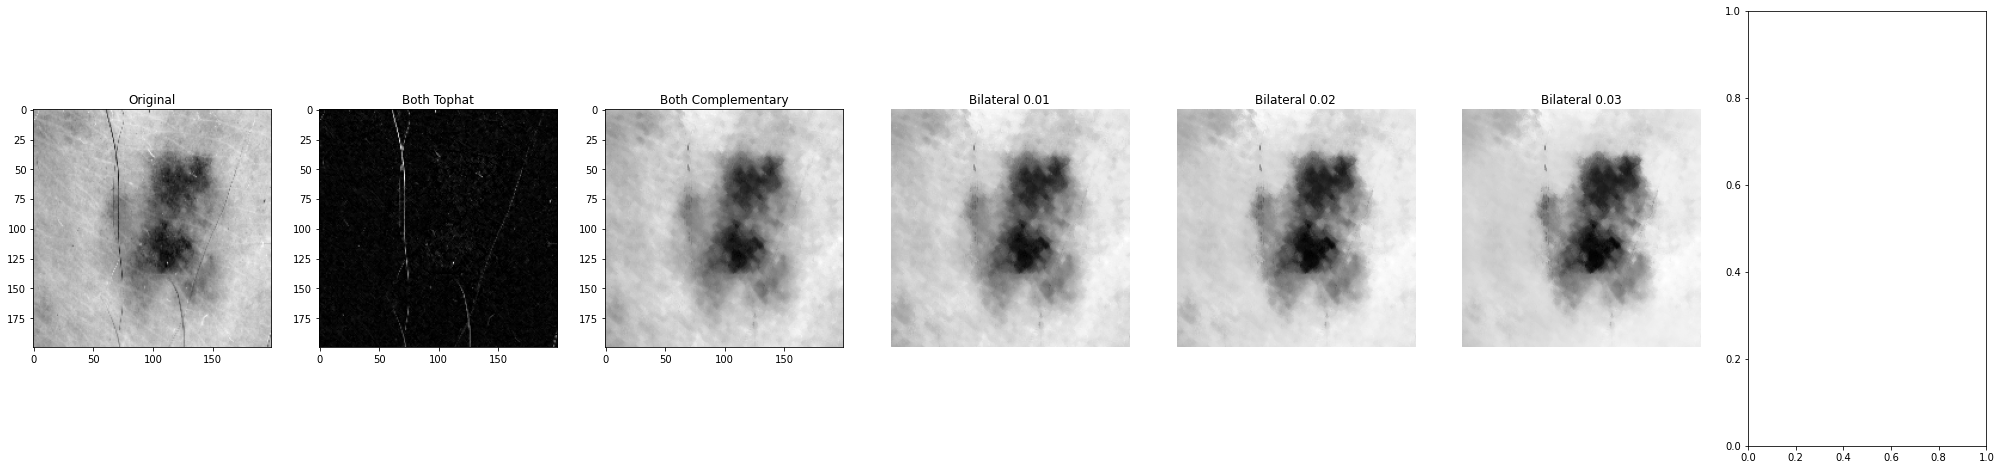

In [7]:
for idx in range(2):
    image = images[idx].copy()
    footprint = morphology.disk(1)
    black_res = morphology.black_tophat(image)# np.array([[(float(pixel)/255.0) for pixel in row] for row in morphology.black_tophat(cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY), footprint)])
    white_res = morphology.white_tophat(image)# np.array([[(float(pixel)/255.0) for pixel in row] for row in morphology.white_tophat(cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY), footprint)])
    fig, ax = plt.subplots(ncols=7, figsize=(35, 8))
    
    ax[0].set_title('Original')
    ax[0].imshow(image, cmap='gray')
    
    ax[1].set_title('Both Tophat')
    ax[1].imshow(black_res + white_res, cmap='gray')
    
    ax[2].set_title('Both Complementary')
    ax[2].imshow(image - white_res + black_res, cmap='gray')
    
    ax[3].imshow(denoise_bilateral(image- white_res + black_res, sigma_color=0.01, sigma_spatial=15,
                    channel_axis=-1,multichannel=False), cmap='gray')
    ax[3].axis('off')
    ax[3].set_title('Bilateral 0.01')
    
    ax[4].imshow(denoise_bilateral(image- white_res + black_res, sigma_color=0.02, sigma_spatial=15,
                    channel_axis=-1,multichannel=False), cmap='gray')
    ax[4].axis('off')
    ax[4].set_title('Bilateral 0.02')
    
    ax[5].imshow(denoise_bilateral(image- white_res + black_res, sigma_color=0.03, sigma_spatial=15,
                    channel_axis=-1,multichannel=False), cmap='gray')
    ax[5].axis('off')
    ax[5].set_title('Bilateral 0.03')

    plt.show()

## Notes

### Both white and black tophat removal, with disk(1) are beneficial. Will do further comparisions with disks size 2,3,4, and see if there are visual improvements of losses.
##### https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.black_tophat, https://scikit-image.org/docs/stable/auto_examples/filters/plot_tophat.html#sphx-glr-auto-examples-filters-plot-tophat-py
### ------------------

### Bilateral is best noise remover, tested all others and dont give desired clarity (https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise.html#sphx-glr-auto-examples-filters-plot-denoise-py).with sigma_color in [0.2,0.3] having the best effect. At this moment it may be pertinent to try CNNs with both types and see which is better.

### ------------------

### Next job is to test disk sizes

In [8]:
# for idx in range(10):
#     image = cv2.cvtColor(images[idx], cv2.COLOR_BGR2GRAY)
#     fig, ax = plt.subplots(ncols=7, figsize=(35, 8))
    
#     ax[0].set_title('Original')
#     ax[0].imshow(image, cmap='gray')
    
#     footprint = morphology.disk(1)
#     black_res = morphology.black_tophat(image, footprint)
#     white_res = morphology.white_tophat(image, footprint)
#     ax[1].set_title('Both Tophat')
#     ax[1].imshow(black_res + white_res, cmap='gray')
#     ax[2].set_title('Both Complementary')
#     ax[2].imshow(image - white_res + black_res, cmap='gray')
    
#     footprint = morphology.disk(2)
#     black_res = morphology.black_tophat(image, footprint)
#     white_res = morphology.white_tophat(image, footprint)
#     ax[3].set_title('Both Tophat')
#     ax[3].imshow(black_res + white_res, cmap='gray')
#     ax[4].set_title('Both Complementary')
#     ax[4].imshow(image - white_res + black_res, cmap='gray')
    
#     footprint = morphology.disk(3)
#     black_res = morphology.black_tophat(image, footprint)
#     white_res = morphology.white_tophat(image, footprint)
#     ax[5].set_title('Both Tophat')
#     ax[5].imshow(black_res + white_res, cmap='gray')
#     ax[6].set_title('Both Complementary')
#     ax[6].imshow(image - white_res + black_res, cmap='gray')

## Disk Investigation Results

### Disk size 3 is too large, blurs image. Disk sizes 1 and 2 each have advantages.
#### 1 - It keeps definition higher, but doesnt remove larger hairs. Thinner hairs (often white, sometimes thin black hairs).
#### 2 - It is good at removing the thicker hairs, however may blur image.

### Conclusion - Do CNN with both, use ResNet and SGD from sklearn. Write down all 8 results.

#### Test 1 - Disk size 1, Bilateral 0.02, Resnet
#### Test 2 - Disk size 2, Bilateral 0.02, Resnet
#### Test 3 - Disk size 1, Bilateral 0.03, Resnet
#### Test 4 - Disk size 2, Bilateral 0.03, Resnet
#### Test 5 - Disk size 1, Bilateral 0.02, SGD
#### Test 6 - Disk size 2, Bilateral 0.02, SGD
#### Test 7 - Disk size 1, Bilateral 0.03, SGD
#### Test 8 - Disk size 2, Bilateral 0.03, SGD


#### Extra Tests - RGB, so just Bilateral 0.02 and 0.03

In [9]:
l = len(images)
ct = 0
for j in range(l):
    img = images[j]
    footprint = morphology.disk(1)
    black_res = morphology.black_tophat(img)# np.array([[(float(pixel)/255.0) for pixel in row] for row in morphology.black_tophat(cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY), footprint)])
    white_res = morphology.white_tophat(img)
    images[j] = img - white_res + black_res
    ct+=1
    if ct>=0:
        print(j/l)
        ct-=l/10

0.0
0.0999500748876685
0.199900149775337
0.2999500748876685
0.399900149775337
0.4999500748876685
0.599900149775337
0.6999500748876685
0.799900149775337
0.8999500748876685
0.999900149775337


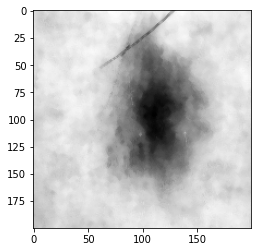

In [11]:
plt.imshow(images[0],cmap="gray")

In [6]:
from sklearn.model_selection import train_test_split as tts

X = images
y = [val[0] for val in trimmed_data.reindex(image_ids).values]

X = np.array(X)#.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_train, X_test, y_train, y_test = tts(X,y,test_size=0.2)

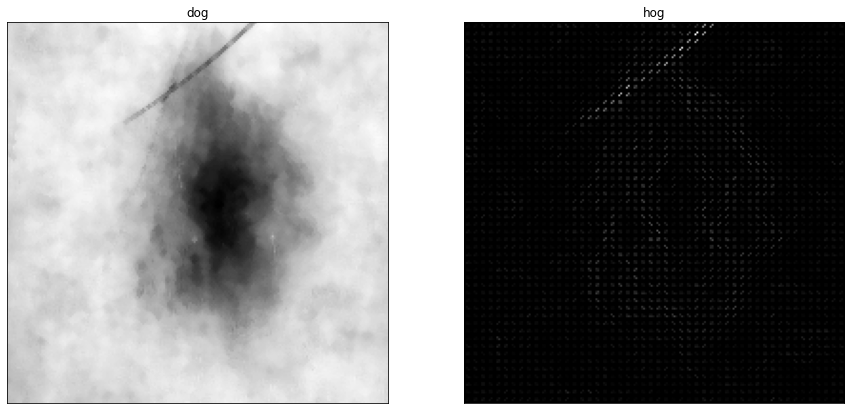

In [13]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

dog = images[0]

# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(4,4), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,15)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]

ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [14]:
np.array(images[0]).shape

(200, 200)

In [15]:
print(dog_hog)

[0.30157047 0.         0.09184015 ... 0.00615545 0.08573555 0.27626267]


In [16]:
import numpy

In [17]:
import imageio

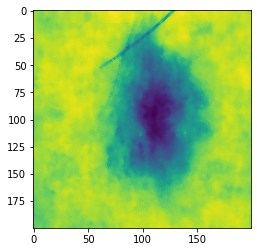

In [18]:
plt.imshow(dog)

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 


In [21]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(12,12), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
# X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(8012, 8100)


In [22]:
X_train = X_train.reshape(8012,-1)
X_train.shape

(8012, 40000)

In [23]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3,verbose=1,n_jobs=-1)
sgd_clf.fit(X_train_prepared, y_train)

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 1793.33, NNZs: 8100, Bias: -6354.743748, T: 8012, Avg. loss: 1834.067062
Total training time: 0.19 seconds.
Norm: 2240.90, NNZs: 8100, Bias: -5466.526966, T: 8012, Avg. loss: 2384.020158
Total training time: 0.19 seconds.
-- Epoch 2
-- Epoch 2
Norm: 1639.73, NNZs: 8100, Bias: -6618.294587, T: 8012, Avg. loss: 1753.913658
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 1918.84, NNZs: 8100, Bias: -6275.959309, T: 8012, Avg. loss: 1983.951167
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 1591.10, NNZs: 8100, Bias: -6508.837570, T: 8012, Avg. loss: 1678.253855
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 2199.20, NNZs: 8100, Bias: -5629.076150, T: 8012, Avg. loss: 2261.369260
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 2604.43, NNZs: 8100, Bias: 2618.256674, T: 8012, Avg. loss: 2526.098003
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 1331.57, NNZs: 8100, Bias: -6217.491718, T: 16024, Avg. loss: 151.335747
Total training time: 0.38 seconds.
-- Epoch 3
N

[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.3min finished
C:\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(n_jobs=-1, random_state=42, verbose=1)

In [24]:
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)
# X_test = X_test.reshape(2003,-1)
# X_test.shape

In [25]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True  True  True  True False False  True  True
  True False  True  True False False False  True  True False False  True
  True]

Percentage correct:  64.45332001997005


In [26]:
print(y_test[1])

4
